In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from sklearn.model_selection import train_test_split

from ml_tools import make_cross_validation, make_grid_search_clf, plot_roc_curve

### Data Preparation

In [2]:
def load_data(filename):
    return pd.read_csv("data/" + filename)

target_name = "multiplier"
data = pd.concat([load_data("data2014.csv"), load_data("data2015.csv")])
X, y = data.drop(target_name, axis=1), data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

Prepare data for classification

In [3]:
def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

# bins = np.linspace(-2, 2, 5)
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.linspace(0, 2, 3)

y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)

/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


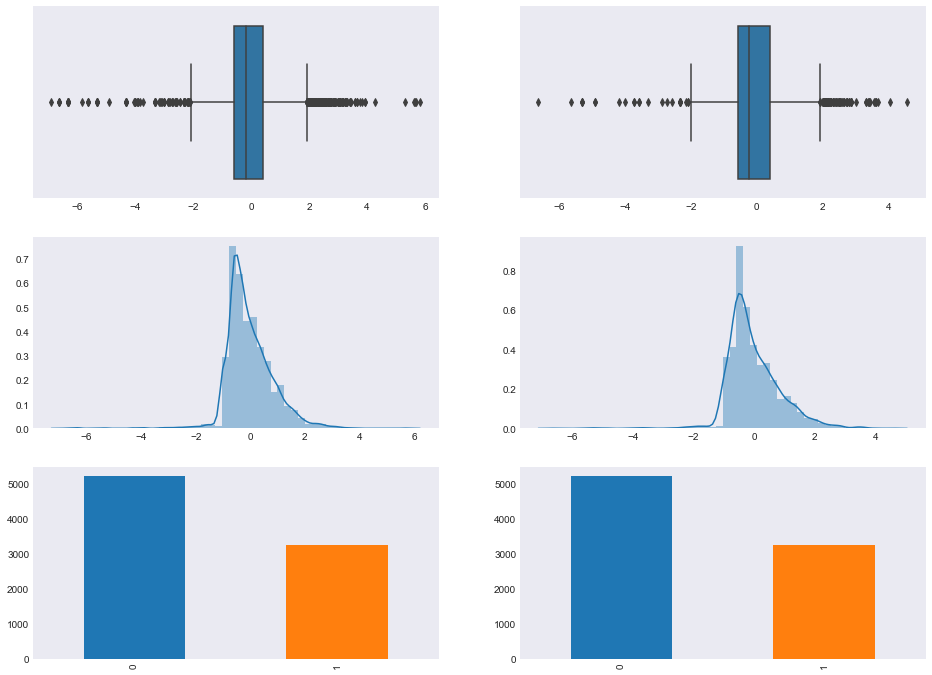

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(16,12))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_train_bins])):
    sns.boxplot(np.log2(series), ax=axs[0, i % 3])
    sns.distplot(np.log2(series), ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar(ax=axs[2, i % 3])
    [ax.set_xlabel("") for ax in axs[:, i % 3]]

### Classification

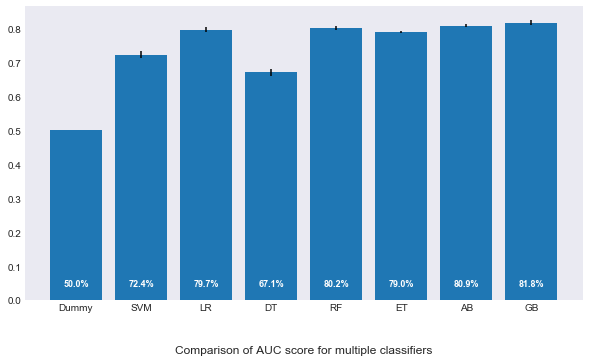

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    
]

cv_results = make_cross_validation(models, scoring, X_train, y_train_bins)

In [6]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier(criterion='entropy', splitter='random')  #max_features="auto", max_depth=None)

classifiers = [
#     ("LogisticRegression", LogisticRegression()), 
    ("AdaBoost", AdaBoostClassifier(base_estimator=base_dt)),
#     ("GradientBoosting", GradientBoostingClassifier())
]

clf_params = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoost": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "base_estimator__max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "base_estimator__max_depth": range(3, 16, 4),
        "learning_rate": np.logspace(-2, 1, 4),
        "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoosting": {

    },
}

best_models, gs_results = make_grid_search_clf(classifiers, clf_params, X_train, y_train_bins, X_test, y_test_bins)


AdaBoost:

	Accuracy: 77.20%
	AUC Score (Train set): 76.49%
	AUC Score (Test set): 75.32%

             precision    recall  f1-score   support

          0       0.81      0.83      0.82      1767
          1       0.70      0.68      0.69      1062

avg / total       0.77      0.77      0.77      2829

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.01, n_estimators=70, random_state=None) 



In [8]:
plot_roc_curve(classifiers, best_models, X_test, y_test_bins)

NameError: name 'best_models' is not defined

In [14]:
clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Coefficients"] = clf.coef_[0]
coef.sort_values("Coefficients", ascending=False)

,Coefficients
Followers,1.506
StartPrice,0.892
Forced,0.717
SP.EV,0.497
LotNr,0.082
LotsCtgry,0.080
Allocate,-0.135
Evening,-0.198
Morning,-0.260
Dealer,-0.297


In [30]:
# sns.pairplot(train.loc[:, train.nunique() != 2])
# plt.savefig("pairplot.png")

In [3]:
# # Confidence Threshold
# alpha = .1

# np.random.seed(42)  # To make sure our results are reproducible
# anova_filter = SelectKBest()
# anova_filter.fit(X_train, y_train)


# anova_scores = pd.DataFrame(index=X_train.columns)
# anova_scores["Fisher"] = anova_filter.scores_
# anova_scores["p-value"] = anova_filter.pvalues_
# anova_scores = anova_scores.sort_values("Fisher", ascending=False)
# # selected_features = list(anova_scores.loc[anova_scores["p-value"] < 1 - alpha, :].index)
# # if len(selected_features) == X_train.shape[1]:
# #     print("No discarded feature")
# # X = X[selected_features]
# anova_scores.style.apply(lambda f: ["color: red"] * 2 if f["p-value"] > 1-alpha else ["color: black"]*2, axis=1)

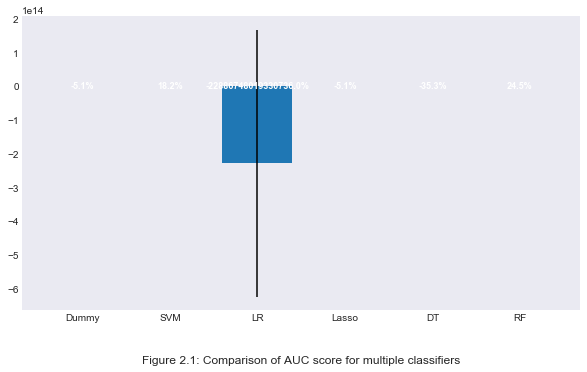

In [14]:
from sklearn.metrics import (
    r2_score, 
    explained_variance_score, 
    mean_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error,
    median_absolute_error
)

from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


scoring = "r2"

metrics = [
    r2_score, 
    explained_variance_score, 
    mean_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error,
    median_absolute_error
]

models = [
    
    ("Dummy", DummyRegressor(strategy="mean")),
    ("SVM", SVR()), 
    ("LR", LinearRegression()),
    ("Lasso", Lasso()),
#     ("LARS", LassoLars()),
    ("DT", DecisionTreeRegressor()), 
    ("RF", RandomForestRegressor())

]

results = OrderedDict()
for name, model in models:
    kfold = KFold(n_splits=3)
    cv_results = cross_val_score(model, X_train_transformed, np.log2(y_train), cv=kfold, scoring=scoring)
    results[name] = cv_results
    
results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.bar(range(results.shape[1]), results.mean(), yerr=results.std())
plt.gca().set_xticklabels([""] + list(results.columns) + [""])
plt.title("Figure 2.1: Comparison of AUC score for multiple classifiers", y=-.2)
plt.subplots_adjust(bottom=.2)
label_barchart(plt.gca())


In [ ]:
n_features = X_train.shape[1]

classifiers = [
#     ("LR", LinearRegression()),
#     ("Lasso", Lasso()),
#     ("DT", DecisionTreeRegressor()),
#     ("RF", RandomForestRegressor(n_estimators=50)),
    ("SVM", SVC())
]

all_params = {
    "LR": {"normalize": [True, False]}, 
    "Lasso": {"alpha": np.logspace(-3, 3, 7)},
    "RF": {
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "DT": {
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "SVM": {
        "C": np.logspace(-2, 2, 5),
        "epsilon": np.logspace(-2, 2, 5),
        "kernel": ["linear", "rbf", "sigmoid"],
    }
}
results = pd.DataFrame(index=[item[0] for item in classifiers], 
                       columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te", 
                                "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])


best_models, scores = [], []
for i, ((name, clf)) in enumerate(classifiers):
    params = all_params[name]
    gs = RandomizedSearchCV(clf, params, n_jobs=-1, verbose=5).fit(X_train, y_train)
    best_models.append(gs.best_estimator_)
    y_pred = gs.predict(X_test)
#     precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    r2_score_te = r2_score(y_test, y_pred)
    r2_score_tr = gs.best_score_
#     accuracy = (y_pred == y_test).mean()
    params = gs.best_params_
    print(f"{name}:\nscore: train {r2_score_tr} test {r2_score_te}\nparams:")
    pprint(params)
#     [[TP, FN], [FP, TN]] = confusion_matrix(y_test, y_pred)
#     results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision, 
#                             recall, fscore, support, TP, FP, FN, TN)
    
#     scores.append(roc_auc_score(y_test, y_pred))
#     gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
#     print("\n{}:\n".format(name))
#     print("\tAccuracy: {:.2%}".format((y_pred == y_test).mean()))
#     print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
#     print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
#     print(classification_report(y_test, y_pred))
#     print(best_models[-1], "\n")
#     if i + 1 < len(classifiers): print("#" * 100)
    
#results
